# Load


In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

# 1️⃣ Load Data
data = pd.read_csv("filtered_stock_data.csv")


# Feature Engineering adding ma5 etc


In [2]:
# 2️⃣ Feature Engineering (Creating MA5, MA10, Volume Change, etc.)
data['MA5'] = data['close'].rolling(window=5).mean()
data['MA10'] = data['close'].rolling(window=10).mean()
data['MA20'] = data['close'].rolling(window=20).mean()
data['volume_change'] = data['volume'].pct_change()
data['price_change'] = data['close'].pct_change()


# 1️⃣ Define Target Variable
data["Target"] = np.where(data["close"].shift(-1) > data["close"], 1, 0)  # 1 = Price Up, 0 = Price Down

# 2️⃣ Drop the last row (since we can't predict future values for the last row)
data.dropna(inplace=True)

# 3️⃣ Select Features and Target
features = ["open", "high", "low", "close", "adj. close", "volume", "dividend", 
            "shares outstanding", "MA5", "MA10", "MA20", "volume_change", "price_change"]
target = "Target"

X = data[features]
y = data[target]


In [3]:
features.append("industryid")  # Ensure categorical feature is in the feature list


In [4]:
# Add 'industryid' to features (if not already present)
if "industryid" not in features:
    features.append("industryid")

print("🔍 Checking Features Before Train-Test Split:")
print(features)  # Should now contain 'industryid'

# Create X and y
X = data[features]
y = data["Target"]

print("🔍 Checking Columns in X Before Train-Test Split:")
print(X.columns)  # Should include 'industryid'


🔍 Checking Features Before Train-Test Split:
['open', 'high', 'low', 'close', 'adj. close', 'volume', 'dividend', 'shares outstanding', 'MA5', 'MA10', 'MA20', 'volume_change', 'price_change', 'industryid']
🔍 Checking Columns in X Before Train-Test Split:
Index(['open', 'high', 'low', 'close', 'adj. close', 'volume', 'dividend',
       'shares outstanding', 'MA5', 'MA10', 'MA20', 'volume_change',
       'price_change', 'industryid'],
      dtype='object')


# train test split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("🔍 Checking Columns in X_train After Split:")
print(X_train.columns)  # Should now include 'industryid'


🔍 Checking Columns in X_train After Split:
Index(['open', 'high', 'low', 'close', 'adj. close', 'volume', 'dividend',
       'shares outstanding', 'MA5', 'MA10', 'MA20', 'volume_change',
       'price_change', 'industryid'],
      dtype='object')


# checking if infinite values exist

In [6]:
# Select only numeric columns
numeric_cols = X_train.select_dtypes(include=[np.number]).columns

# Check for infinite values in numeric columns only
print("🔍 Checking for Infinite Values (inf) in Numeric Columns:")
print(np.isinf(X_train[numeric_cols]).sum())  # Should be all 0s
print(np.isinf(X_test[numeric_cols]).sum())   # Should be all 0s


🔍 Checking for Infinite Values (inf) in Numeric Columns:
open                  0
high                  0
low                   0
close                 0
adj. close            0
volume                0
dividend              0
shares outstanding    0
MA5                   0
MA10                  0
MA20                  0
volume_change         0
price_change          0
industryid            0
dtype: int64
open                  0
high                  0
low                   0
close                 0
adj. close            0
volume                0
dividend              0
shares outstanding    0
MA5                   0
MA10                  0
MA20                  0
volume_change         0
price_change          0
industryid            0
dtype: int64


# fix infinite values if they exist

In [7]:
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)
X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)

# Data Scalling

In [8]:
X_train["industryid"] = X_train["industryid"].astype(str)
X_test["industryid"] = X_test["industryid"].astype(str)


In [9]:
from sklearn.preprocessing import LabelEncoder

# Initialize Label Encoder
label_encoder = LabelEncoder()

# Fit & Transform `industryid`
X_train["industryid"] = label_encoder.fit_transform(X_train["industryid"])
X_test["industryid"] = label_encoder.transform(X_test["industryid"])


In [10]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
joblib.dump(scaler, "scaler.pkl")
print("✅ Scaling Successful!")


✅ Scaling Successful!


# Logistic reg model

In [11]:
log_model = LogisticRegression()
log_model.fit(X_train_scaled, y_train)
log_y_pred = log_model.predict(X_test_scaled)
log_accuracy = accuracy_score(y_test, log_y_pred)
print(f"⚠️ Logistic Regression Accuracy (BAD MODEL): {log_accuracy * 100:.2f}%")
print("\nClassification Report:\n", classification_report(y_test, log_y_pred))
joblib.dump(log_model, "stock_prediction_logistic.pkl")


⚠️ Logistic Regression Accuracy (BAD MODEL): 53.60%

Classification Report:
               precision    recall  f1-score   support

           0       0.54      0.52      0.53       622
           1       0.53      0.55      0.54       615

    accuracy                           0.54      1237
   macro avg       0.54      0.54      0.54      1237
weighted avg       0.54      0.54      0.54      1237



['stock_prediction_logistic.pkl']

# cnfusion matrix for the bad model

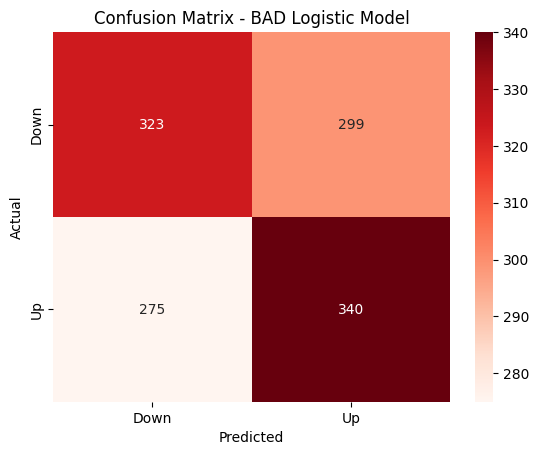

In [12]:
conf_matrix_log = confusion_matrix(y_test, log_y_pred)
sns.heatmap(conf_matrix_log, annot=True, fmt="d", cmap="Reds", xticklabels=["Down", "Up"], yticklabels=["Down", "Up"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - BAD Logistic Model")
plt.show()

# SMOTE

this part isnt working properly its taking forever to run im assuming its due to the dataset is too large nd theres alot of oversampling happening

In [13]:
print(X_train_scaled.shape)
print(y_train.shape)

(4944, 14)
(4944,)


In [15]:
from imblearn.over_sampling import SMOTE
from collections import Counter

# Check class distribution before SMOTE
print("🔍 Class Distribution Before SMOTE:")
print(y_train.value_counts())

# Dynamically adjust the sampling strategy to avoid errors
smote = SMOTE(sampling_strategy="auto", random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Check new class distribution
print("✅ Class Distribution After SMOTE:")
print(Counter(y_train_resampled))  # Should now be balanced


🔍 Class Distribution Before SMOTE:
Target
1    2487
0    2457
Name: count, dtype: int64
✅ Class Distribution After SMOTE:
Counter({0: 2487, 1: 2487})


# Random forest

In [18]:
# Train a Random Forest model (Improved)
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)

# Make predictions
rf_y_pred = rf_model.predict(X_test_scaled)

# Evaluate performance
rf_accuracy = accuracy_score(y_test, rf_y_pred)
print(f"✅ Random Forest Accuracy (IMPROVED MODEL): {rf_accuracy * 100:.2f}%")
print("\nClassification Report:\n", classification_report(y_test, rf_y_pred))

# Save the trained model
joblib.dump(rf_model, "stock_prediction_rf.pkl")
print("✅ Improved Model Saved as 'stock_prediction_rf.pkl'")


✅ Random Forest Accuracy (IMPROVED MODEL): 49.88%

Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.51      0.51       622
           1       0.50      0.49      0.49       615

    accuracy                           0.50      1237
   macro avg       0.50      0.50      0.50      1237
weighted avg       0.50      0.50      0.50      1237

✅ Improved Model Saved as 'stock_prediction_rf.pkl'


# confusion matrix improved model

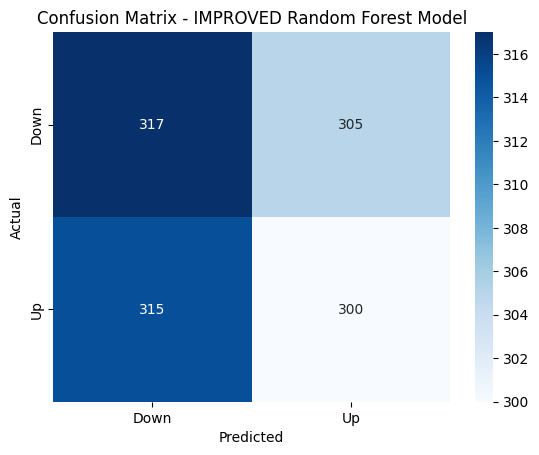

🎯 Model Training Completed! Use 'stock_prediction_rf.pkl' for predictions.


In [17]:
conf_matrix_rf = confusion_matrix(y_test, rf_y_pred)
sns.heatmap(conf_matrix_rf, annot=True, fmt="d", cmap="Blues", xticklabels=["Down", "Up"], yticklabels=["Down", "Up"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - IMPROVED Random Forest Model")
plt.show()

print("🎯 Model Training Completed! Use 'stock_prediction_rf.pkl' for predictions.")
